In [4]:
import os 
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

from monai.losses import DiceLoss


from src.models import UpNet 
from src.datagen import CustomImageDataset
from src.losses import dice_loss

c:\Users\Betato\miniconda3\envs\torch-py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
import sys
config = "512pixel_4ro"
drive_path = "drive/MyDrive/TFM/Pruebas/"
local_path = rf"D:\TFM\Dataset_20230313\{config}/Data/"
drive_path = drive_path if os.path.exists(drive_path) else local_path
sys.path.append(drive_path)

In [19]:
import pandas as pd
annotations_df = pd.DataFrame(os.listdir(drive_path) , columns=['filename'])
annotations_df = annotations_df[annotations_df['filename'].apply(lambda x: not x.endswith(".csv"))]

In [17]:
validation_files = ["HS_Davos_20200406_2m_epsg2056",
"HS_Laucherenalp_20220224_2m_epsg2056",
"HS_Laucherenalp_20220511_1m_epsg2056",
"HS_Saflischpass_20220512_1m_epsg2056",
"HS_c_20220223_1m_epsg2056"]

annotations_df['mapchete'] = annotations_df['filename'].apply(lambda x: x.split("__")[1].replace(".pickle", ""))
annotations_df['file'] = annotations_df['filename'].apply(lambda x: x.split("__")[0].replace(".pickle", ""))

aux1 = annotations_df[annotations_df['file'].apply(lambda x: "snowmap" in x)]
aux1.to_csv(local_path.replace("/Data", "") + "annotations_df_pretrain.csv")

aux2 = annotations_df[annotations_df['file'].apply(lambda x: "snowmap" not in x)]

validation  = aux2[aux2['file'].apply(lambda x: x in validation_files)]
validation.to_csv(local_path.replace("/Data", "") + "annotations_df_val.csv")

train = aux2[aux2['file'].apply(lambda x: x not in validation_files)]
train.to_csv(local_path.replace("/Data", "") + "annotations_df.csv")

In [5]:
ini_channels = 4
out_channels = 1
width = 4
depth = 4
batch_size = 64
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

annotations_df = drive_path + "annotations_df.csv"
annotations_df_val = drive_path + "annotations_df_val.csv"
annotations_df_pret = drive_path + "annotations_df_pretrain.csv"

In [6]:
unet = UpNet(ini_channels, out_channels, width, depth).to(device).double()


cid_pret = CustomImageDataset(annotations_df_pret, drive_path)
pretrainloader = DataLoader(cid_pret, batch_size=batch_size, shuffle=False)

cid = CustomImageDataset(annotations_df, drive_path)
trainloader = DataLoader(cid, batch_size=batch_size, shuffle=False)


cid_val = CustomImageDataset(annotations_df_val, drive_path)
validationloader = DataLoader(cid_val, batch_size=batch_size, shuffle=False)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

loss_fn = nn.BCEWithLogitsLoss()

loss_fn = nn.MSELoss()
    
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-3, eps=1e-4)

In [15]:
(labels[0] - outputs[0]).detach().numpy().squeeze().shape

(128, 128)

N items 83


  0%|          | 0/83 [00:00<?, ?it/s]

[1,     1] loss: 1.185
loss		 1.185


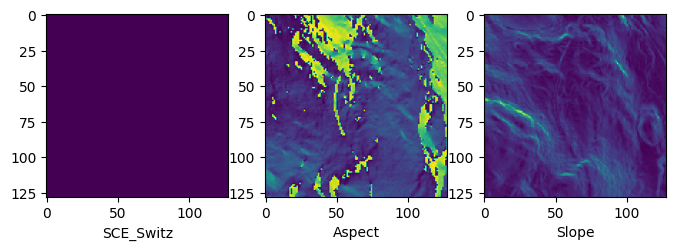

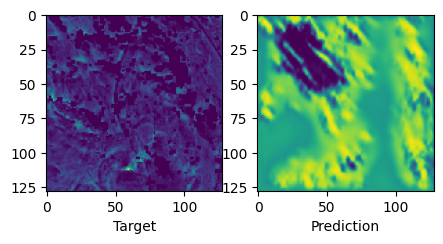

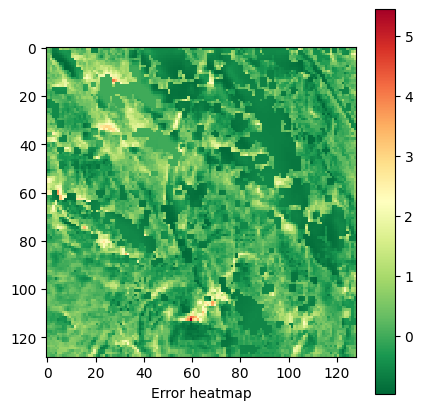

 29%|██▉       | 24/83 [01:44<05:44,  5.84s/it]

[1,    25] loss: 1.199
loss		 1.142


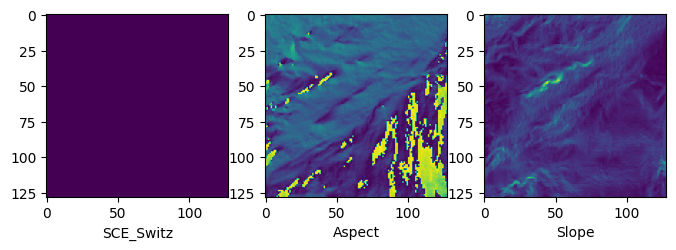

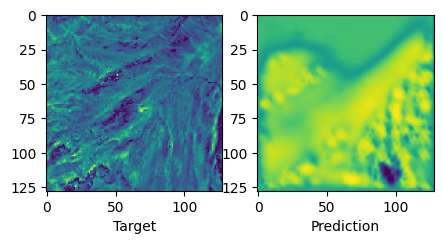

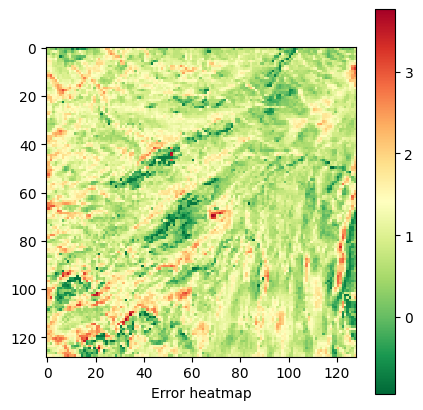

 58%|█████▊    | 48/83 [04:06<03:00,  5.17s/it]

[1,    49] loss: 1.142
loss		 1.147


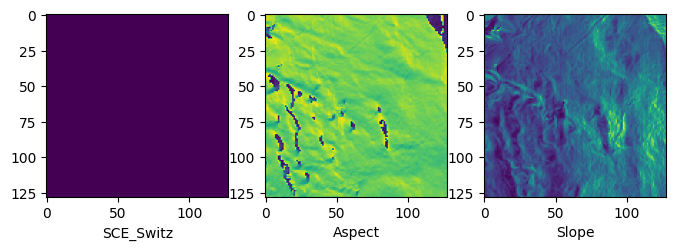

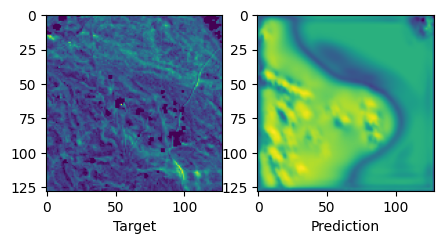

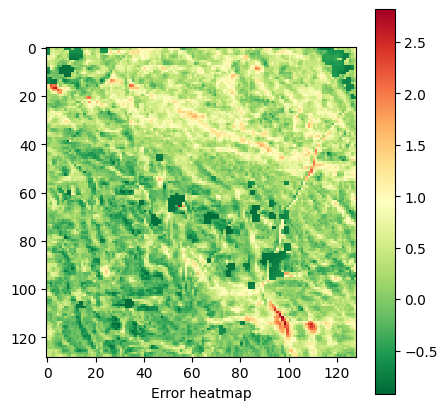

 87%|████████▋ | 72/83 [06:29<01:08,  6.27s/it]

[1,    73] loss: 1.319
loss		 2.316


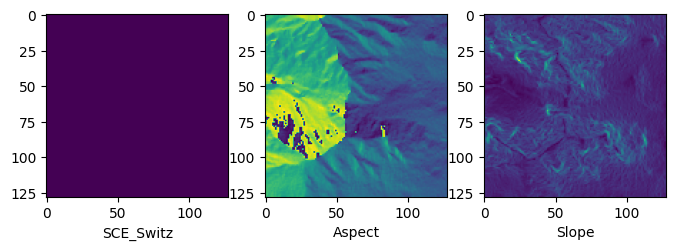

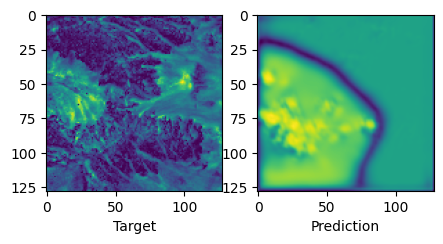

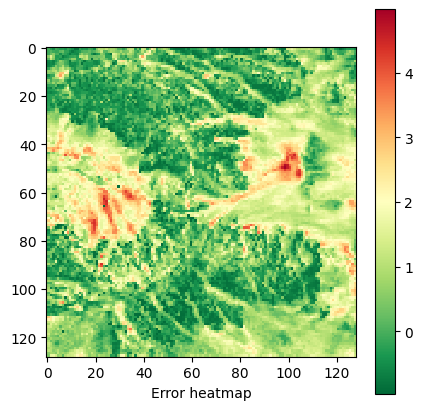

 99%|█████████▉| 82/83 [07:43<00:06,  6.41s/it]

[1,    83] loss: 1.407
loss		 2.157


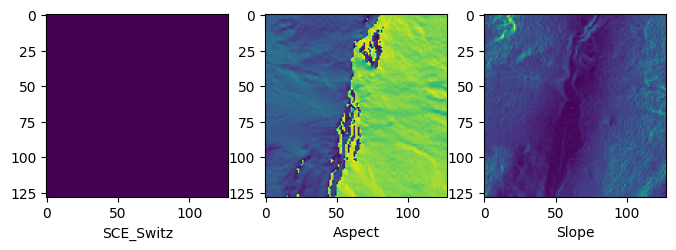

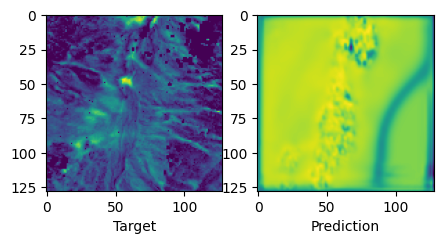

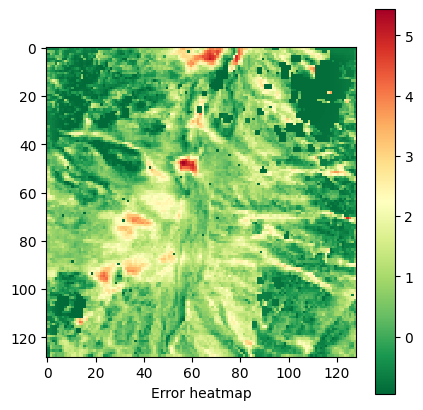

100%|██████████| 83/83 [07:49<00:00,  5.66s/it]


Proceding with validation


100%|██████████| 27/27 [01:56<00:00,  4.33s/it]


VALIDATION: 0.945350048311416


  0%|          | 0/83 [00:00<?, ?it/s]

[2,     1] loss: 0.892
loss		 0.892


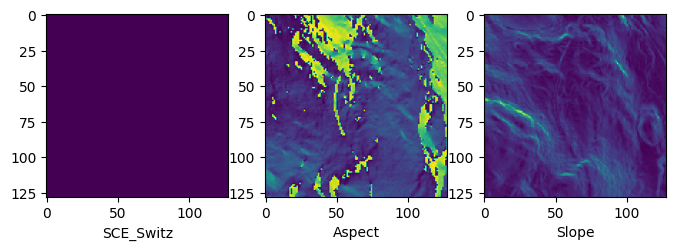

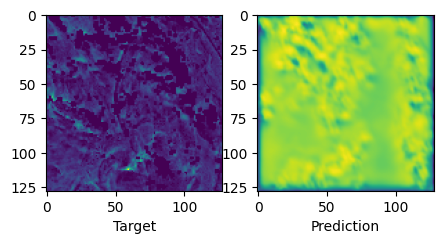

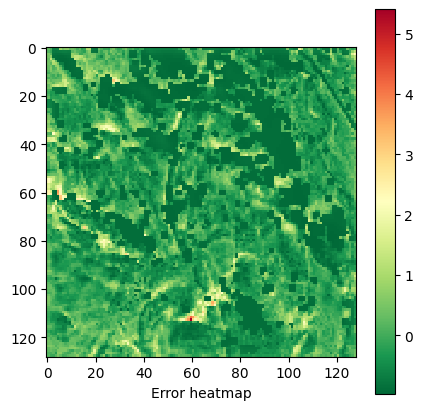

 29%|██▉       | 24/83 [01:40<03:49,  3.89s/it]

[2,    25] loss: 0.933
loss		 0.928


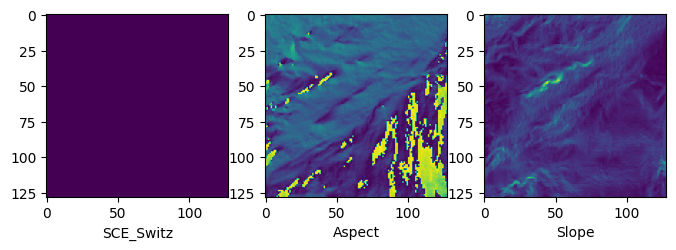

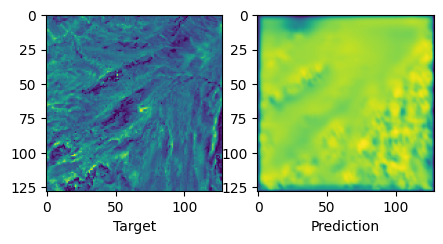

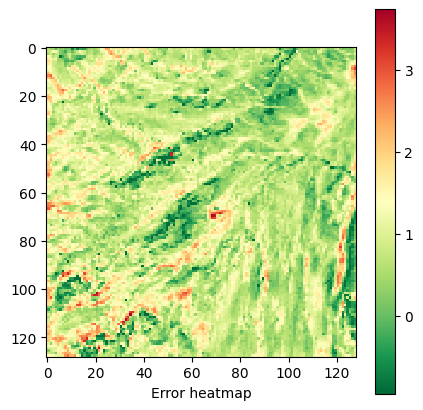

 58%|█████▊    | 48/83 [03:20<02:13,  3.80s/it]

[2,    49] loss: 0.926
loss		 0.987


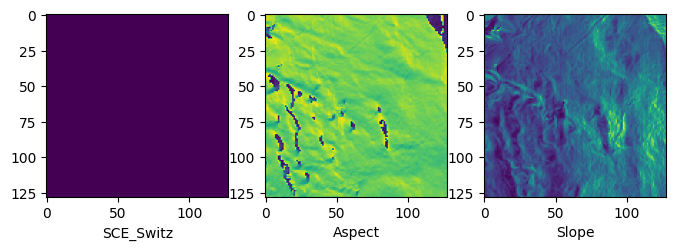

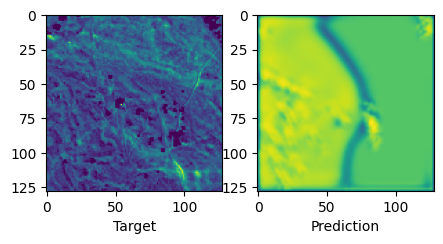

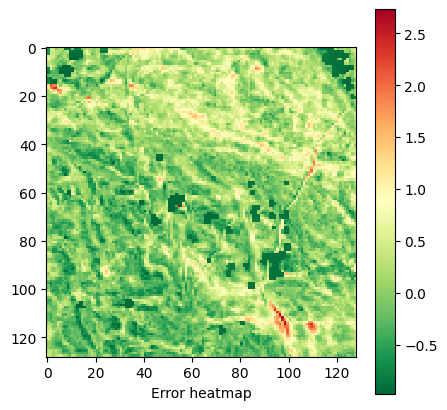

 87%|████████▋ | 72/83 [04:56<00:43,  3.92s/it]

[2,    73] loss: 1.113
loss		 2.122


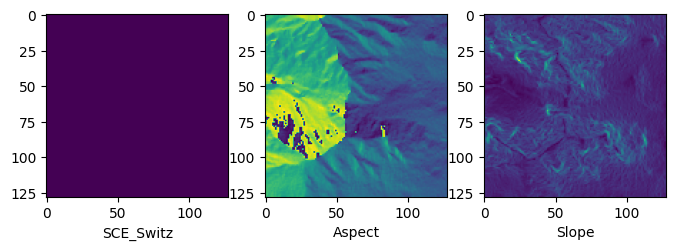

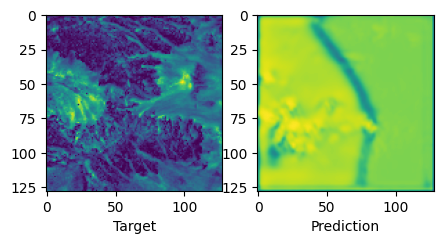

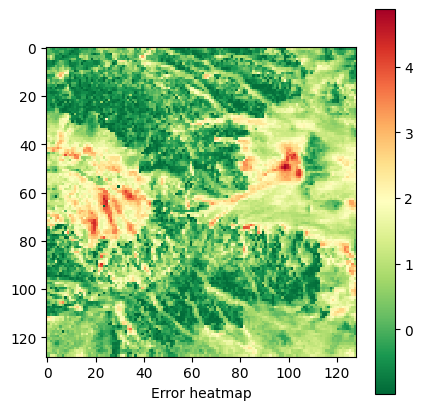

 99%|█████████▉| 82/83 [05:36<00:03,  3.81s/it]

[2,    83] loss: 1.206
loss		 1.948


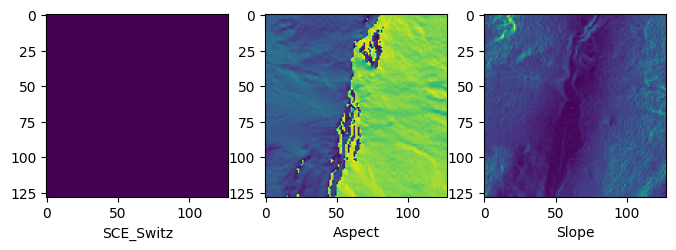

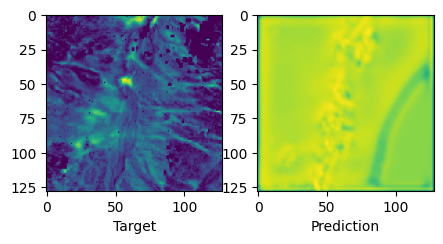

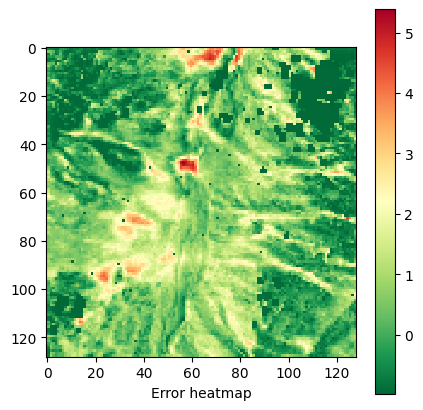

100%|██████████| 83/83 [05:41<00:00,  4.12s/it]


Proceding with validation


100%|██████████| 27/27 [01:02<00:00,  2.33s/it]


VALIDATION: 0.9110230122570473


  0%|          | 0/83 [00:00<?, ?it/s]

[3,     1] loss: 0.821
loss		 0.821


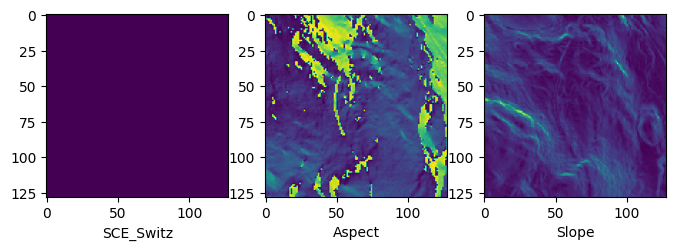

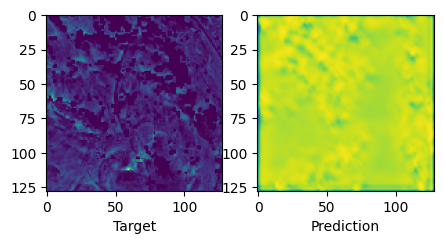

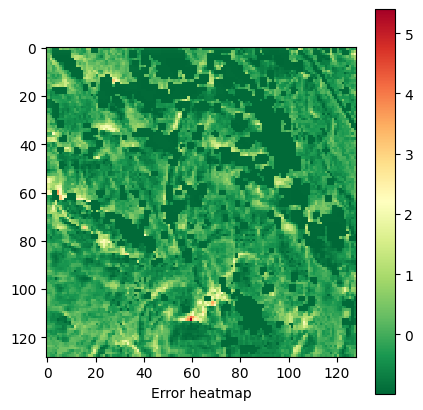

 29%|██▉       | 24/83 [01:36<04:00,  4.08s/it]

[3,    25] loss: 0.871
loss		 0.875


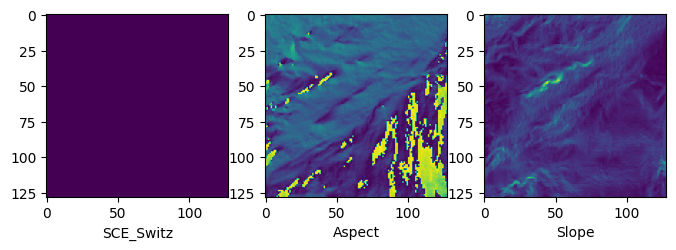

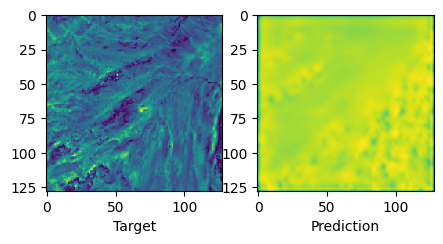

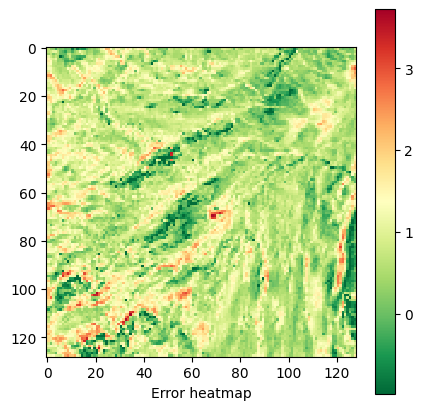

 48%|████▊     | 40/83 [02:59<03:12,  4.48s/it]


KeyboardInterrupt: 

In [49]:
def MSE(y_true, y_pred, mask):
    delta = (y_true-y_pred) ** 2
    return delta[mask==1].nanmean()

def MAE(y_true, y_pred, mask):
    delta = abs(y_true-y_pred)
    return delta[mask==1].nanmean()

n_items = len(trainloader)
n_items_val = len(validationloader)
print("N items", n_items)

torch.cuda.empty_cache()

glob_loss = []
glob_validation = []
for epoch in range(20):  # loop over the dataset multiple times
    running_loss = []
    validations = []
    for i, data in tqdm(enumerate(trainloader, 0), total=n_items):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device) , labels.to(device)
        
#         scaler = GradScaler()
            
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        
       
        loss = MSE(outputs.to(device), labels.double(), inputs[:, -1].unsqueeze(1)).double()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())           
        
        if i % 24 == 0 or i == n_items-1:
            mean_loss = np.array(running_loss).mean()
            glob_loss.append(mean_loss)
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {mean_loss :.3f}')
            
            
            print("loss\t\t", round(loss.item(), 3))
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))
            
            ax1.set_xlabel("SCE_Switz")
            ax2.set_xlabel("Aspect")
            ax3.set_xlabel("Slope")
            
            ax1.imshow(inputs[0][0])
            ax2.imshow(inputs[0][1])
            ax3.imshow(inputs[0][2])
            
            plt.show()
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))
            
            ax1.set_xlabel("Target")
            ax2.set_xlabel("Prediction")

            ax1.imshow(labels[0].squeeze())
            ax2.imshow(outputs[0].detach().numpy().squeeze())
            plt.show()
            
            fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
            delta = (labels[0] - outputs[0]).detach().numpy().squeeze()
            ax1.set_xlabel("Error heatmap")
            ax1.imshow(delta, cmap="RdYlGn_r")            
            fig.colorbar(ax1.pcolormesh(delta, cmap="RdYlGn_r"))
            plt.show()
        
    print("Proceding with validation")
            
    for i, data in tqdm(enumerate(validationloader, 0), total=n_items_val):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device) , labels.to(device)
        with torch.no_grad():
            outputs = unet(inputs)
            valm = MAE(outputs, labels, inputs[:, -1].unsqueeze(1))
            validations.append(valm)
    
    mean_val = np.array(validations).mean()
    glob_validation.append(mean_val)
    print("VALIDATION:", mean_val)
    
    running_loss = []
    validations = []